In [107]:
import keras
from keras.layers import Input, Dense
from keras.models import Model
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.utils import class_weight
from sklearn.metrics import roc_auc_score
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt


In [2]:
FEATURE_PATH = "./homework/features/mcc_features.csv"
feature_df = pd.read_csv(FEATURE_PATH)
feature_df.head()
r = feature_df.groupby("SNAME").apply(lambda df:\
                                       df.shape[0])
good_names = {name for name, length in r.iteritems() if length == 474}
feature_df = feature_df[[i in good_names for i in feature_df.SNAME]]

In [3]:
files = sorted(set(feature_df.SNAME))
np.random.seed(5345)
files_train, files_tv = train_test_split(files, test_size=0.2)
files_val, files_test = train_test_split(files_tv, test_size=0.5)
files_train, files_val, files_test = set(files_train), set(files_val), set(files_test)

In [4]:
X_train = feature_df[[i in files_train for i in feature_df.SNAME]]
y_train = X_train.IS_LAUGHTER.values
X_train = X_train.iloc[:, :-2].values
X_val = feature_df[[i in files_val for i in feature_df.SNAME]]
y_val = X_val.IS_LAUGHTER.values
X_val = X_val.iloc[:, :-2].values
X_test = feature_df[[i in files_test for i in feature_df.SNAME]]
y_test = X_test.IS_LAUGHTER.values
X_test = X_test.iloc[:, :-2].values

In [5]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

In [6]:
# inputs = Input(shape=(39,))
batch_size = 474

mfcc_input = Input(shape=(batch_size, 39), name='mfcc_input')
gru1 = keras.layers.GRU(64,
                        stateful=False,
                        return_sequences=True)(mfcc_input)
aux_output = Dense(1, activation='sigmoid', name='aux_output')(gru1)

fbank_input = Input(shape=(batch_size, 13), name='fbank_input')
gru2 = keras.layers.GRU(20,
                        stateful=False,
                        return_sequences=True)(fbank_input)

x = keras.layers.concatenate([gru1, gru2])
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)

main_output = Dense(1, activation='sigmoid', name='main_output')(x)

model = Model(inputs=[mfcc_input, fbank_input], outputs=[main_output, aux_output])

model.compile(optimizer='adam', loss='binary_crossentropy')

In [69]:
X_mfcc_train = X_train[:, :39]
X_fbank_train = X_train[:, 39:]
X_mfcc_val = X_val[:, :39]
X_fbank_val = X_val[:, 39:]
X_mfcc_test = X_test[:, :39]
X_fbank_test = X_test[:, 39:]
mfcc_seq_train = tf.convert_to_tensor(np.array([X_mfcc_train[batch_size * i : batch_size * (i+1)] for i in range(X_mfcc_train.shape[0] // batch_size)]))
fbank_seq_train = tf.convert_to_tensor(np.array([X_fbank_train[batch_size * i : batch_size * (i+1)] for i in range(X_fbank_train.shape[0] // batch_size)]))
mfcc_seq_val = tf.convert_to_tensor(np.array([X_mfcc_val[batch_size * i : batch_size * (i+1)] for i in range(X_mfcc_val.shape[0] // batch_size)]))
fbank_seq_val = tf.convert_to_tensor(np.array([X_fbank_val[batch_size * i : batch_size * (i+1)] for i in range(X_fbank_val.shape[0] // batch_size)]))
mfcc_seq_test = tf.convert_to_tensor(np.array([X_mfcc_test[batch_size * i : batch_size * (i+1)] for i in range(X_mfcc_test.shape[0] // batch_size)]))
fbank_seq_test = tf.convert_to_tensor(np.array([X_fbank_test[batch_size * i : batch_size * (i+1)] for i in range(X_fbank_test.shape[0] // batch_size)]))
y_train_seq = tf.convert_to_tensor(np.array([y_train[batch_size * i : batch_size * (i+1)] for i in range(y_train.shape[0] // batch_size)]).astype(np.float64))
y_val_seq = tf.convert_to_tensor(np.array([y_val[batch_size * i : batch_size * (i+1)] for i in range(y_val.shape[0] // batch_size)]).astype(np.float64))
y_test_seq = tf.convert_to_tensor(np.array([y_test[batch_size * i : batch_size * (i+1)] for i in range(y_test.shape[0] // batch_size)]).astype(np.float64))
y_train_seq = tf.reshape(y_train_seq, (list(y_train_seq.shape) + [1]))
y_val_seq = tf.reshape(y_val_seq, (list(y_val_seq.shape) + [1]))
y_test_seq = tf.reshape(y_test_seq, (list(y_test_seq.shape) + [1]))


In [35]:


print(mfcc_seq_train.shape, fbank_seq_train.shape)
print(y_train_seq.shape)
model.fit({'mfcc_input': mfcc_seq_train, 'fbank_input': fbank_seq_train},
          {'main_output': y_train_seq, 'aux_output': y_train_seq},
          epochs=mfcc_seq_train.shape[0].value // 10,
          verbose=1,
          callbacks=None,
          validation_data=({'mfcc_input': mfcc_seq_val, 'fbank_input': fbank_seq_val},
                           {'main_output': y_val_seq, 'aux_output': y_val_seq}),
          shuffle=True,
          class_weight={0 : class_weights[0], 1 : class_weights[1]},
          sample_weight=None,
          initial_epoch=0,
          steps_per_epoch=10,
          validation_steps=10)

(2188, 474, 39) (2188, 474, 13)
(2188, 474, 1)
Train on 2188 samples, validate on 273 samples
Epoch 1/218
10/10 [==============================] - 308s 31s/step - loss: 0.1354 - main_output_loss: 0.0527 - aux_output_loss: 0.0828 - val_loss: 0.1837 - val_main_output_loss: 0.0865 - val_aux_output_loss: 0.0972
Epoch 2/218
10/10 [==============================] - 242s 24s/step - loss: 0.1373 - main_output_loss: 0.0537 - aux_output_loss: 0.0837 - val_loss: 0.1796 - val_main_output_loss: 0.0845 - val_aux_output_loss: 0.0951
Epoch 3/218
10/10 [==============================] - 198s 20s/step - loss: 0.1416 - main_output_loss: 0.0569 - aux_output_loss: 0.0846 - val_loss: 0.1787 - val_main_output_loss: 0.0843 - val_aux_output_loss: 0.0945
Epoch 4/218
10/10 [==============================] - 207s 21s/step - loss: 0.1446 - main_output_loss: 0.0582 - aux_output_loss: 0.0864 - val_loss: 0.1847 - val_main_output_loss: 0.0877 - val_aux_output_loss: 0.0970
Epoch 5/218
10/10 [===========================

10/10 [==============================] - 194s 19s/step - loss: 0.1295 - main_output_loss: 0.0516 - aux_output_loss: 0.0779 - val_loss: 0.1825 - val_main_output_loss: 0.0852 - val_aux_output_loss: 0.0973
Epoch 39/218
10/10 [==============================] - 184s 18s/step - loss: 0.1276 - main_output_loss: 0.0509 - aux_output_loss: 0.0767 - val_loss: 0.1842 - val_main_output_loss: 0.0865 - val_aux_output_loss: 0.0977
Epoch 40/218
10/10 [==============================] - 186s 19s/step - loss: 0.1269 - main_output_loss: 0.0506 - aux_output_loss: 0.0763 - val_loss: 0.1835 - val_main_output_loss: 0.0873 - val_aux_output_loss: 0.0962
Epoch 41/218
10/10 [==============================] - 191s 19s/step - loss: 0.1291 - main_output_loss: 0.0515 - aux_output_loss: 0.0776 - val_loss: 0.1850 - val_main_output_loss: 0.0878 - val_aux_output_loss: 0.0972
Epoch 42/218
10/10 [==============================] - 190s 19s/step - loss: 0.1503 - main_output_loss: 0.0580 - aux_output_loss: 0.0923 - val_loss: 0

Epoch 76/218
10/10 [==============================] - 188s 19s/step - loss: 0.1258 - main_output_loss: 0.0501 - aux_output_loss: 0.0757 - val_loss: 0.1867 - val_main_output_loss: 0.0865 - val_aux_output_loss: 0.1002
Epoch 77/218
10/10 [==============================] - 170s 17s/step - loss: 0.1330 - main_output_loss: 0.0536 - aux_output_loss: 0.0794 - val_loss: 0.1811 - val_main_output_loss: 0.0834 - val_aux_output_loss: 0.0977
Epoch 78/218
10/10 [==============================] - 167s 17s/step - loss: 0.1301 - main_output_loss: 0.0520 - aux_output_loss: 0.0781 - val_loss: 0.1821 - val_main_output_loss: 0.0852 - val_aux_output_loss: 0.0969
Epoch 79/218
10/10 [==============================] - 187s 19s/step - loss: 0.1247 - main_output_loss: 0.0499 - aux_output_loss: 0.0748 - val_loss: 0.1846 - val_main_output_loss: 0.0866 - val_aux_output_loss: 0.0980
Epoch 80/218
10/10 [==============================] - 186s 19s/step - loss: 0.1228 - main_output_loss: 0.0490 - aux_output_loss: 0.0738 

Epoch 114/218
10/10 [==============================] - 195s 20s/step - loss: 0.1352 - main_output_loss: 0.0539 - aux_output_loss: 0.0813 - val_loss: 0.1843 - val_main_output_loss: 0.0870 - val_aux_output_loss: 0.0973
Epoch 115/218
10/10 [==============================] - 191s 19s/step - loss: 0.1289 - main_output_loss: 0.0518 - aux_output_loss: 0.0771 - val_loss: 0.1841 - val_main_output_loss: 0.0875 - val_aux_output_loss: 0.0967
Epoch 116/218
10/10 [==============================] - 191s 19s/step - loss: 0.1262 - main_output_loss: 0.0510 - aux_output_loss: 0.0752 - val_loss: 0.1871 - val_main_output_loss: 0.0886 - val_aux_output_loss: 0.0985
Epoch 117/218
10/10 [==============================] - 185s 18s/step - loss: 0.1232 - main_output_loss: 0.0495 - aux_output_loss: 0.0737 - val_loss: 0.1827 - val_main_output_loss: 0.0857 - val_aux_output_loss: 0.0970
Epoch 118/218
10/10 [==============================] - 189s 19s/step - loss: 0.1216 - main_output_loss: 0.0486 - aux_output_loss: 0.

KeyboardInterrupt: 

In [156]:
model.save("./homework/models/rnn2")

In [70]:
# res_train = np.squeeze(model.predict(X_train))
# res_test = np.squeeze(model.predict(mf))

#fbank_seq_val.shape[0].value
res_val = model.predict({'mfcc_input': mfcc_seq_val, 'fbank_input': fbank_seq_val}, steps=1, verbose=1)[0].reshape(y_val.shape[0])
res_test = model.predict({'mfcc_input': mfcc_seq_test, 'fbank_input': fbank_seq_test}, steps=1, verbose=1)[0].reshape(y_test.shape[0])

1/1 [==============================] - 34s 34s/step


In [71]:
roc_auc_score(y_val, res_val)

0.9333865206923233

In [72]:
roc_auc_score(y_test, res_test)

0.9451532022053066

In [134]:
# 6
def plot_kth_probs(k):
    label_num = k
    test_files_ids = sorted([int(sname[1:]) for sname in files_test])
    # sname = sorted(files_test, key = lambda)[label_num]
    print(f"file #{test_files_ids[label_num]}")
    with open("../../vocalizationcorpus/labels.txt") as inp:
        for i in range((test_files_ids[label_num]) + 1):
            st = inp.readline()
        st = st.strip().split(',')
        intervals = [(float(st[i+1]), float(st[i+2])) for i in range(4, len(st)) if st[i] == 'laughter']
    print("laugter intervals:", intervals)
    answers = res_test[label_num * batch_size : (label_num + 1) * batch_size]
    plt.figure(figsize=(15, 10))
    plt.plot(np.linspace(0, 11, answers.shape[0]), answers)
    for p in intervals:
        plt.axvline(p[0], linestyle='--', color='red')
        plt.text(p[0], -0.1, "start", fontsize=15, rotation=90, color='red')
        plt.axvline(p[1], linestyle='--', color='black')
        plt.text(p[1], -0.1, "end", fontsize=15, rotation=90, color='black')
    plt.show()

file #98
laugter intervals: [(6.278, 8.796)]


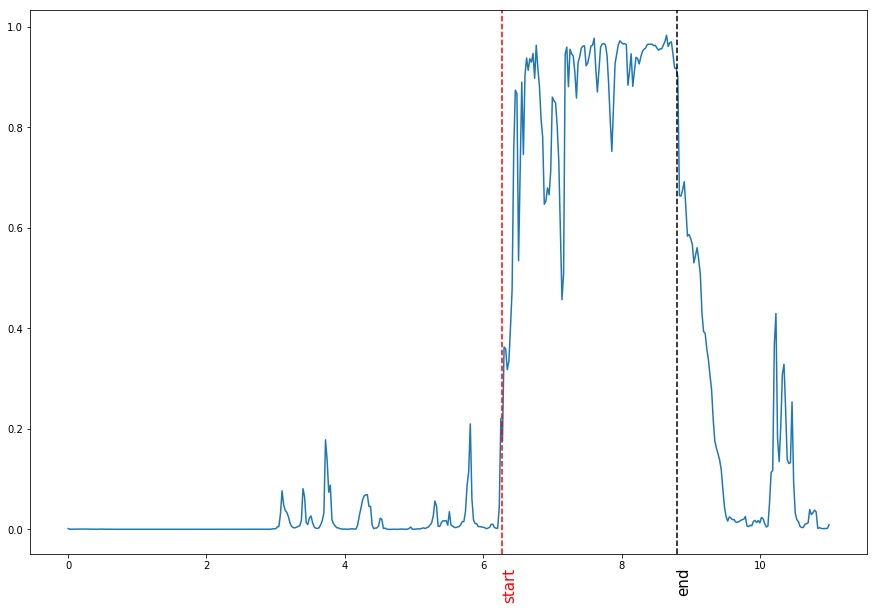

In [137]:
plot_kth_probs(9)

file #115
laugter intervals: [(2.172, 2.717)]


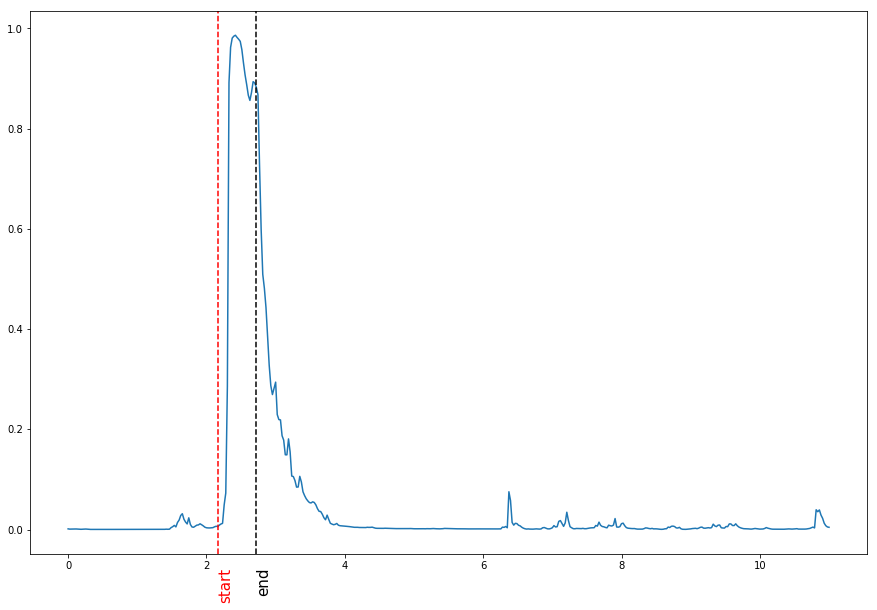

In [139]:
plot_kth_probs(11)

file #1464
laugter intervals: [(5.313, 6.177), (6.485, 6.914), (10.164, 10.847)]


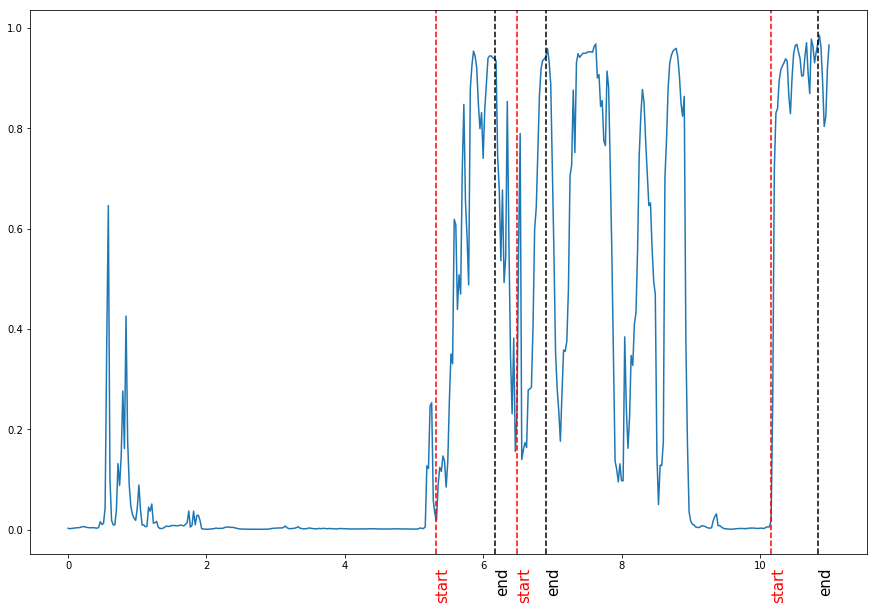

In [142]:
plot_kth_probs(160)

file #653
laugter intervals: [(4.715, 5.311)]


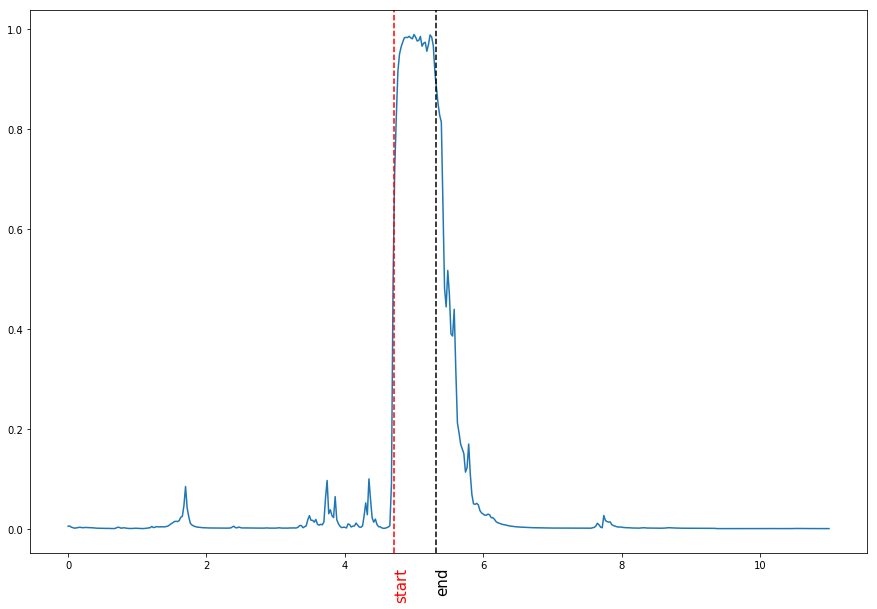

In [155]:
plot_kth_probs(70)